In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys

import torch

from pathlib import Path
from models.unet import *
from utils.plot import *
from utils.data_loader import *

In [3]:
CT_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\ct")
MASK_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\masks")

In [4]:
ds = CTSlices(CT_DIR, MASK_DIR)

In [5]:
model = UNet(n_channels=1, kernel_size=3, ds=1).cuda()
model.eval()

UNet(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_1): ConvBlock(
    (body): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_2): ConvBlock(
    (body): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_3): ConvBlock(
    (body): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down_4): ConvBlock(
    (body): Sequential(
      (0): Conv2d(256, 512, kernel_si

In [6]:
WEIGHT_DIR = Path("weights")
WEIGHT_PATH = WEIGHT_DIR / "best_weights.h5"
checkpoint = torch.load(WEIGHT_PATH)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [7]:
dataloader = DataLoader(
    ds, 
    batch_size=1,                   
    shuffle=False,
    pin_memory=False,
    num_workers=0,
)

In [8]:
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return -(numerator + 1) / (denominator + 1)

loss_obj = dice_loss

100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it, loss=0.4088]


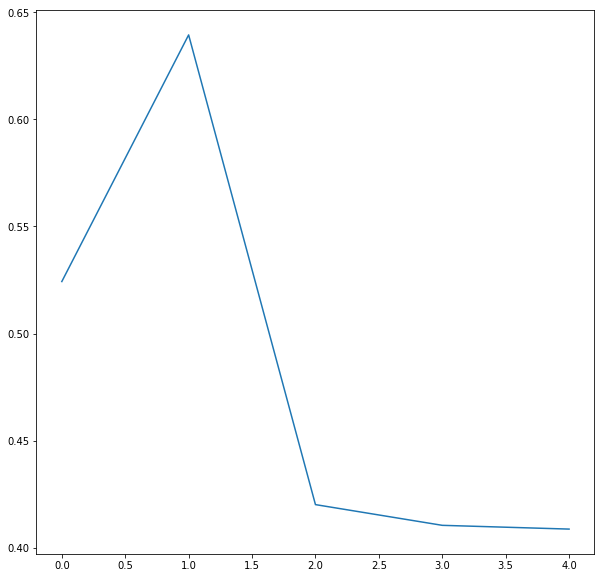

In [9]:
losses = []

with tqdm(total=len(dataloader)) as pbar:
    for xs, ys in dataloader:
        ys_hat = model(xs)
        loss = dice_loss(ys_hat, ys)
        
        losses.append(-loss.detach().cpu().numpy())

        pbar.set_postfix(
            {
                'loss': '{:.4f}'.format(losses[-1]),
            }
        )
        pbar.update(1)
plt.plot(losses)
plt.show()

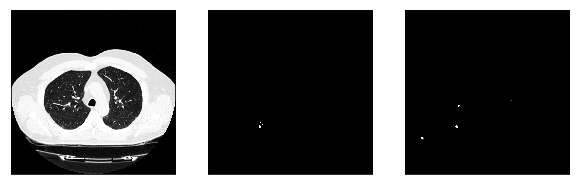

In [10]:
multiplot([
    xs[0,0].detach().cpu().numpy(),
    ys[0,0].detach().cpu().numpy(),
    ys_hat[0,0].detach().cpu().numpy(),
])

# OOD Images

In [11]:
def pad_and_resize(x, target_shape=512):

    pads = tuple(
        (0, np.abs(d - max(x.shape)))
        for d in x.shape
    )
    
    x = np.pad(x, pads)
    
    x = np.array(Image.fromarray(x).resize((target_shape, target_shape)))
    return x

In [12]:
def norm(x):
    return x / x.max()

In [13]:
from PIL import Image, ImageOps

In [14]:
OOD_DIR = Path("D:\data\covid\MosMedData Chest CT Scans with COVID-19 Related Findings COVID19_1110 1.0\holdout\ood")

In [15]:
ood_fpaths = sorted(OOD_DIR.iterdir())

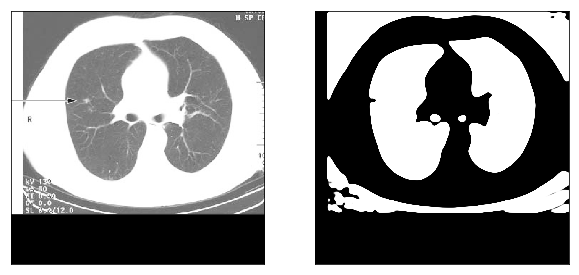

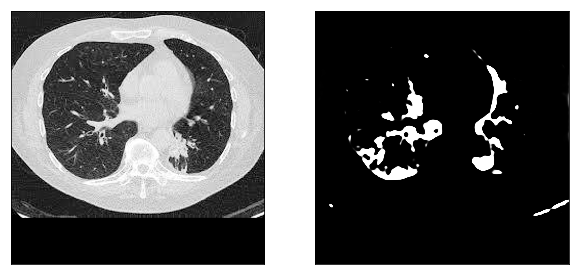

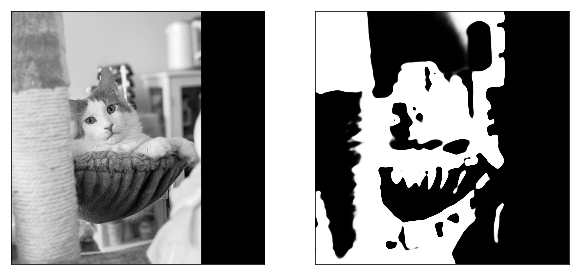

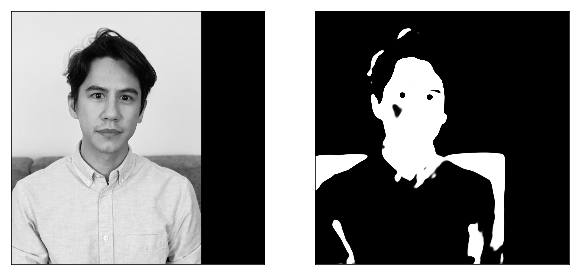

In [16]:
for fpath in ood_fpaths:
    x = ImageOps.grayscale(Image.open(fpath))
    x = np.array(x)
    x = norm(pad_and_resize(x))
    x = torch.from_numpy(x[np.newaxis, np.newaxis, ...])
    x = x.float().cuda()
    y_hat = model(x)
    
    multiplot([
        np.rot90(x[0,0].detach().cpu().numpy(), k=3),
        np.rot90(y_hat[0,0].detach().cpu().numpy(), k=3),
    ])